<a href="https://colab.research.google.com/github/abyanjan/Kaggle-leaf-disease-classification/blob/master/leaf_disease_classification_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Get the Data

Download data directly from kaggle following the discussion here https://www.kaggle.com/c/cassava-leaf-disease-classification/discussion/198299

In [ ]:
# https://www.kaggle.com/c/cassava-leaf-disease-classification/discussion/198299

In [ ]:
!pip uninstall -y kaggle

Uninstalling kaggle-1.5.10:
  Successfully uninstalled kaggle-1.5.10


In [ ]:
!pip install kaggle

     |████████████████████████████████| 61kB 5.2MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=13b9db06930677facbda85adf415e74fbcf1ff28ab92d7de1c5a7d770f89c6be
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle


In [ ]:
import os

os.environ["KAGGLE_USERNAME"] = ''
os.environ["KAGGLE_KEY"] = ''

In [ ]:
# Download the data from the kaggle competition

raw_data_dir = "input/raw"

!kaggle competitions download -c cassava-leaf-disease-classification -p {raw_data_dir}

100% 5.76G/5.76G [02:05<00:00, 41.4MB/s]
100% 5.76G/5.76G [02:05<00:00, 49.4MB/s]


In [ ]:
# Check that the zip file was downloaded
!ls {raw_data_dir}

cassava-leaf-disease-classification.zip


In [ ]:
# Fuze-zip allows us to access zipped folders without
# first unzipping them. This is helpful when working
# with large files.

!apt-get install -y fuse-zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libzip4
The following NEW packages will be installed:
  fuse-zip libzip4
0 upgraded, 2 newly installed, 0 to remove and 15 not upgraded.
Need to get 65.6 kB of archives.
After this operation, 178 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libzip4 amd64 1.1.2-1.1 [37.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fuse-zip amd64 0.4.4-1 [27.9 kB]
Fetched 65.6 kB in 1s (85.4 kB/s)
Selecting previously unselected package libzip4:amd64.
(Reading database ... 145480 files and directories currently installed.)
Preparing to unpack .../libzip4_1.1.2-1.1_amd64.deb ...
Unpacking libzip4:amd64 (1.1.2-1.1) ...
Selecting previously unselected package fuse-zip.
Preparing to unpack .../fuse-zip_0.4.4-1_amd64.deb ...
Unpacking fuse-zip (0.4.4-1) ...
Setting up libzip4:amd64 (

In [ ]:
# Apply fuze-zip to the  data

input_dir = "/tmp/kaggle-data"
!mkdir {input_dir}
!fuse-zip input/raw/cassava-leaf-disease-classification.zip {input_dir}

In [ ]:
# Check that everything is working.
!ls {input_dir}

label_num_to_disease_map.json  test_images     train.csv     train_tfrecords
sample_submission.csv	       test_tfrecords  train_images


In [ ]:
# Use this path to access the downloaded folders

base_path = '/tmp/kaggle-data/'

os.listdir(base_path)

['label_num_to_disease_map.json',
 'sample_submission.csv',
 'test_images',
 'test_tfrecords',
 'train.csv',
 'train_images',
 'train_tfrecords']

In [ ]:
#! [ -e /content ] && pip install -Uqq fastai 
!pip install fastai --upgrade

In [ ]:
import pandas as pd
import numpy as np
import os

In [ ]:
import torch
import fastai
from fastai.vision.all import *
from fastai.callback import *

In [ ]:
print(fastai.__version__)

2.1.10


In [ ]:
# reading train data
df = pd.read_csv(os.path.join(base_path,'train.csv'))
df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [ ]:
# replacing the label values with names
label = {0:'CBB', 1:'CBSD', 2:'CGM', 3:'CMD', 4:'Healthy'}
df['label'] = df.label.map(label)
df.head()

,image_id,label
0,1000015157.jpg,CBB
1,1000201771.jpg,CMD
2,100042118.jpg,CBSD
3,1000723321.jpg,CBSD
4,1000812911.jpg,CMD


In [ ]:
# target label distribution
df.label.value_counts()

CMD        13158
Healthy     2577
CGM         2386
CBSD        2189
CBB         1087
Name: label, dtype: int64

In [ ]:

dl = ImageDataLoaders.from_df(df, path = base_path, 
                              folder='train_images',
                              #csv_fname='train_df.csv',delimeter=',',
                               valid_pct=0.3,fn_col = 0,label_col=1,
                               bs = 32,val_bs = 64,
                               item_tfms = Resize(460, method = 'squish'), 
                               batch_tfms =aug_transforms(mult = 2,flip_vert = True,
                                                          size = 224,max_zoom = 1.2,
                                                          max_rotate=20.0,
                                                         min_scale = 0.75))

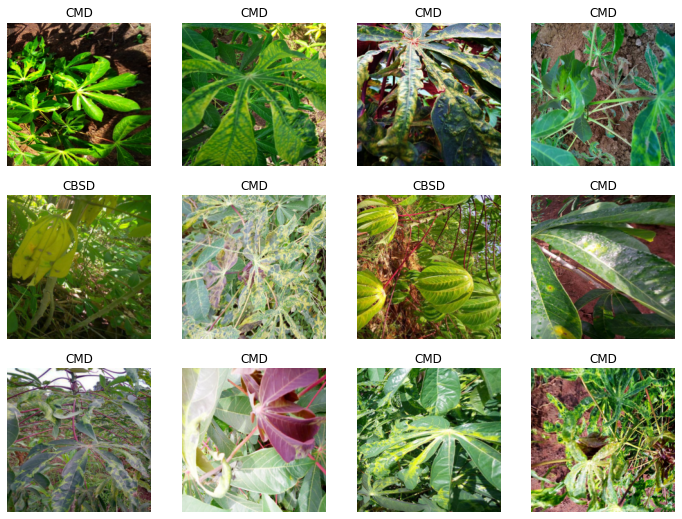

In [ ]:
dl.show_batch(max_n=12)

In [ ]:
# load the  model
model = cnn_learner(dls = dl, arch=resnet50, metrics = accuracy,
                    path = '/content')
                   

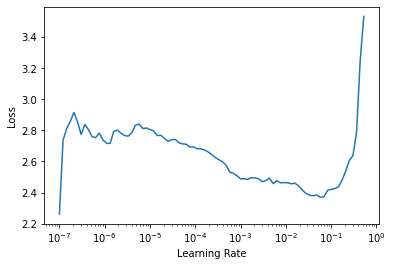

In [ ]:
# find lr
lr_min,lr_steep = model.lr_find()

In [ ]:
print(f'Minimum_lr :{lr_min:.2e},  Steepest_point: {lr_steep:.2e}')


Minimum_lr :5.75e-03,  Steepest_point: 4.79e-04


**Model training**

In [ ]:
callbacks = [ShowGraphCallback(),
            EarlyStoppingCallback( monitor = 'accuracy', min_delta=0.001, patience=4)]

epoch,train_loss,valid_loss,accuracy,time
0,1.506229,1.044482,0.669730,05:32
1,1.056992,0.843307,0.731111,05:20
2,0.779146,0.639502,0.773797,05:19
3,0.670765,0.529867,0.811964,05:19
4,0.603287,0.513141,0.821779,05:28
5,0.548744,0.487203,0.831126,05:26
6,0.506127,0.468043,0.839695,05:28
7,0.533259,0.453662,0.841564,05:25
8,0.490194,0.449018,0.843434,05:23
9,0.483653,0.423995,0.850288,05:24


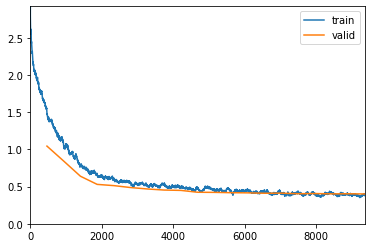

No improvement since epoch 15: early stopping


In [ ]:

model.fit_one_cycle(n_epoch=20, 
                    lr_max = 1e-3,
                    cbs = callbacks)

In [ ]:
# Evaluation
interp = ClassificationInterpretation.from_learner(model)

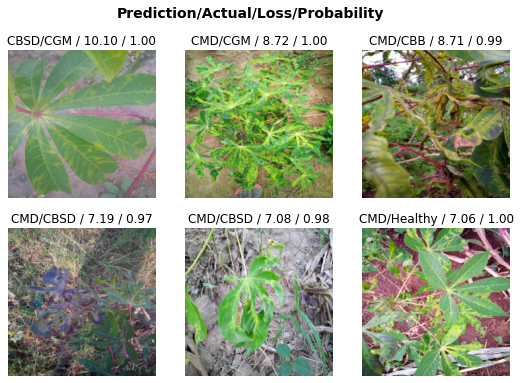

In [ ]:
interp.plot_top_losses(k = 6)

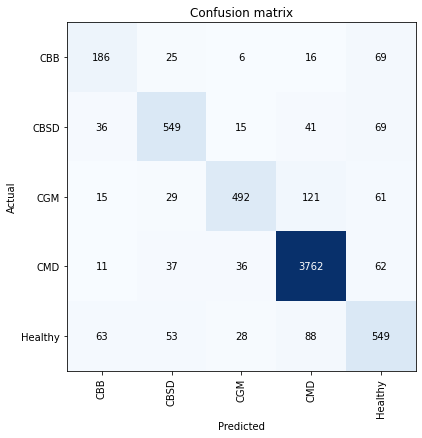

In [ ]:
interp.plot_confusion_matrix(figsize = (8,6))

In [ ]:
model.save('stage_1')

Path('/content/models/stage_1.pth')

Fine Tuning

In [ ]:
# unfreeze the model
model.unfreeze()

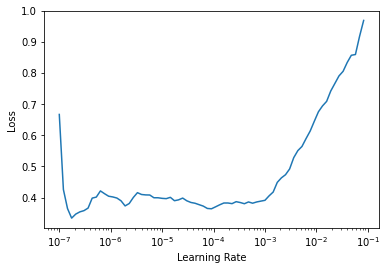

In [ ]:
# find lr
lr_min,lr_steep = model.lr_find()

In [ ]:
print(f'Minimum_lr :{lr_min:.2e},  Steepest_point: {lr_steep:.2e}')

Minimum_lr :9.12e-06,  Steepest_point: 1.58e-06


In [ ]:
callbacks = [ShowGraphCallback(),
            EarlyStoppingCallback( monitor = 'accuracy', min_delta=0.001, patience=4),
            SaveModelCallback(monitor = "accuracy", min_delta=0.001,fname="best_model_1")]

In [ ]:
#model.load('stage_1')
#model.unfreeze()

epoch,train_loss,valid_loss,accuracy,time
0,0.398850,0.432488,0.849665,06:00
1,0.488890,0.479121,0.829880,05:58
2,0.474254,0.464791,0.840785,06:08
3,0.480653,0.416854,0.855118,06:00
4,0.436425,0.409338,0.857922,05:56
5,0.400538,0.404883,0.861193,06:04
6,0.389645,0.387842,0.868204,05:52
7,0.342407,0.385381,0.870696,05:52
8,0.358404,0.388825,0.867269,05:54
9,0.340432,0.385608,0.869917,05:48


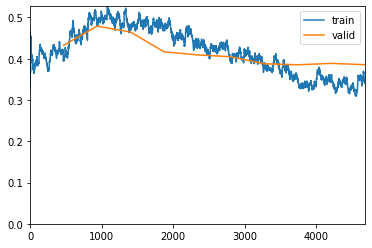

Better model found at epoch 0 with accuracy value: 0.8496650457382202.
Better model found at epoch 3 with accuracy value: 0.8551176190376282.
Better model found at epoch 4 with accuracy value: 0.8579217791557312.
Better model found at epoch 5 with accuracy value: 0.8611933588981628.
Better model found at epoch 6 with accuracy value: 0.8682037591934204.
Better model found at epoch 7 with accuracy value: 0.8706963658332825.


In [ ]:
model.fit_one_cycle(n_epoch=10, lr_max=slice(1e-5, 1e-3),
                   cbs = callbacks)

In [ ]:
model.load('/content/models/best_model_1')

/usr/local/lib/python3.6/dist-packages/fastai/learner.py:55: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [ ]:
# evaluation
interp = ClassificationInterpretation.from_learner(model)

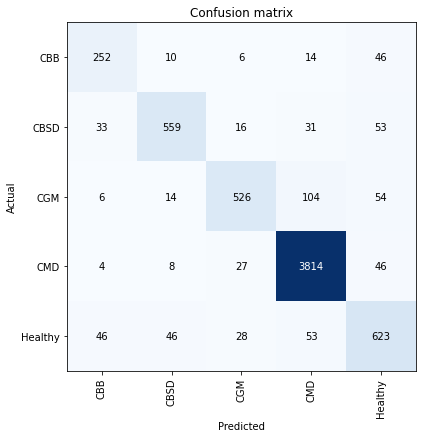

In [ ]:
interp.plot_confusion_matrix(figsize = (8,6))

**Get predictioin for the validation set**

In [ ]:
pred, target = model.get_preds()

In [ ]:
pred

tensor([[1.3742e-02, 9.6071e-01, 7.2840e-04, 1.0942e-03, 2.3728e-02],
        [5.4718e-04, 9.8578e-01, 1.2903e-03, 1.2319e-02, 6.7605e-05],
        [1.4901e-06, 5.9799e-06, 2.1386e-04, 9.9952e-01, 2.5362e-04],
        ...,
        [3.8225e-04, 4.9195e-04, 4.7243e-03, 9.9300e-01, 1.3997e-03],
        [8.6400e-01, 3.1053e-02, 1.8550e-02, 2.0045e-03, 8.4397e-02],
        [1.3696e-02, 2.1913e-02, 4.0858e-02, 6.5339e-03, 9.1700e-01]])

In [ ]:
pred_labels = torch.argmax(pred, 1).numpy()
pred_labels

array([1, 1, 3, ..., 3, 0, 4])

In [ ]:
#label = {0:'CBB', 1:'CBSD', 2:'CGM', 3:'CMD', 4:'Healthy'}
target = target.numpy()
target

array([1, 1, 3, ..., 3, 0, 4])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(target, pred_labels))

              precision    recall  f1-score   support

           0       0.74      0.77      0.75       328
           1       0.88      0.81      0.84       692
           2       0.87      0.75      0.80       704
           3       0.95      0.98      0.96      3899
           4       0.76      0.78      0.77       796

    accuracy                           0.90      6419
   macro avg       0.84      0.82      0.83      6419
weighted avg       0.90      0.90      0.90      6419



In [ ]:
#model.export('/content/drive/MyDrive/Computer vision/leaf_disease.pkl')